In [60]:
import os

import nibabel as nib
import numpy as np
import dipy
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,
                           is_header_compatible)
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.tracking.utils import density_map

In [63]:
import warnings

warnings.simplefilter("ignore")
import numpy as np
import random
import os
import getpass
import subprocess
import vtk

from dipy.viz import window, actor
from argparse import ArgumentParser


def visualize_fibs(fibs,fibsfile,atlasfile, outdir, opacity, num_samples):
    """
    Takes fiber streamlines and visualizes them using DiPy
    Required Arguments:
        - fibsfile: Path to fiber file
        - atlasfile: Path to atlas file
        - outdir: Path to output directory
        - opacity: Opacity of overlayed brain
        - num_samples: number of fibers to randomly sample from fibfile
    Optional Arguments:
    """
    try:
        import pyvtk

        print("pyVTK found - beginning fiber QA.")
    except ImportError:
        print("pyVTK not found; skipping fiber QA.")
        return

    # loading the fibers
    fibs = threshold_fibers(fibs)

    # make sure if fiber streamlines
    # have no fibers, no error occurs
    if len(fibs) == 0:
        return
    # randomly sample num_samples fibers from given fibers
    resampled_fibs = random_sample(fibs, num_samples)
    # load atlas file
    atlas_volume = load_atlas(atlasfile, opacity)
    
    # Initialize renderer
    renderer = window.Renderer()
    renderer.SetBackground(1.0, 1.0, 1.0)

    # Add streamlines as a DiPy viz object
    from dipy.viz import colormap
    color = colormap.line_colors(fibs)
    stream_actor = actor.line(fibs,colormap.line_colors(fibs))

    # Set camera orientation properties
    # TODO: allow this as an argument
    renderer.set_camera()  # args are: position=(), focal_point=(), view_up=()

    # Add streamlines to viz session
    renderer.add(stream_actor)
    renderer.add(atlas_volume)
    
    # Display fibers
    # TODO: allow size of window as an argument
    # window.show(renderer, size=(600, 600), reset_camera=False)

    fname = os.path.split(fibsfile)[1].split(".")[0] + ".png"
    window.record(renderer, out_path=outdir + fname, size=(600, 600))

    
    print("Finished!")


def threshold_fibers(fibs):
    """
    fibs: fibers as 2D array (N,3)
    """
    fib_lengths = [len(f) for f in fibs]
    if len(fib_lengths) == 0:
        return fib_lengths
    # calculate median of  fiber lengths
    med = np.median(fib_lengths)
    # get only fibers above the median length
    long_fibs = [f for f in fibs if len(f) > med]
    return long_fibs


def random_sample(fibs, num_samples):
    """
    fibs: fibers thresholded above median
    num_samples: number of fibers to sample from fibs
    """
    # if the number of samples is more than amount
    # of fibers available, then make num_samples
    # equal number of fibers available
    if len(fibs) <= num_samples:
        num_samples = len(fibs)
    # generate the random sample indices
    samples = random.sample(list(range(len(fibs))), num_samples)
    return [fibs[i] for i in samples]


def load_atlas(path, opacity):
    """
    path: path to atlas file
    opacity: opacity of overlayed atlas brain
    """
    nifti_reader = vtk.vtkNIFTIImageReader()
    nifti_reader.SetFileName(path)
    nifti_reader.Update()

    # The following class is used to store transparencyv-values for later
    # retrival. In our case, we want the value 0 to be completly opaque
    alphaChannelFunc = vtk.vtkPiecewiseFunction()
    alphaChannelFunc.AddPoint(0, 0.0)
    alphaChannelFunc.AddPoint(1, opacity)

    # This class stores color data and can create color tables from a few color
    # points. For this demo, we want the three cubes to be of the colors red
    # green and blue.
    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(0, 0.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(1, 1.0, 1.0, 1.0)

    # The preavius two classes stored properties. Because we want to apply
    # these properties to the volume we want to render, we have to store them
    # in a class that stores volume prpoperties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(colorFunc)
    volumeProperty.SetScalarOpacity(alphaChannelFunc)
    volumeProperty.ShadeOn()

    # We can finally create our volume. We also have to specify the data for
    # it, as well as how the data will be rendered.
    volumeMapper = vtk.vtkSmartVolumeMapper()
    volumeMapper.SetInputDataObject(nifti_reader.GetOutput())

    # The class vtkVolume is used to pair the preaviusly declared volume as
    # well as the properties to be used when rendering that volume.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    return volume

In [64]:
fibsfile='/Users/zhenhu/Documents/NDD/Downloads/ndmg_outputs/dwi/fiber/streamlines.trk'
atlasfile='/Users/zhenhu/Desktop/qa_fiber/desikan_space-MNI152NLin6_res-2x2x2.nii.gz'
fibs_trk=dipy.io.streamline.load_trk(fibsfile,'same')
fibs=list(fibs_trk.streamlines)

outdir='/Users/zhenhu/Desktop/qa_fiber/'
opacity=1
num_samples=10000
visualize_fibs(fibs,fibsfile,atlasfile,outdir,opacity,num_samples)


pyVTK found - beginning fiber QA.
Finished!


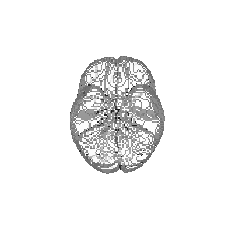

In [65]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np

lena = mpimg.imread('/Users/zhenhu/Desktop/qa_fiber/streamlines.png') 
lena.shape 

plt.imshow(lena) 
plt.axis('off')
plt.show()